In [29]:
using Distributions
using PyPlot
using LaTeXStrings

using Distributed
# addprocs(10)
@everywhere begin

using QuantumCircuits
using QuantumOptics
using Statistics
using Random
using LinearAlgebra

end

In [8]:
@everywhere begin

# Basis
q = SpinBasis(1//2)

# Operators
σx = sigmax(q)
σy = sigmay(q)
σz = sigmaz(q)
id = identityoperator(q)

# Initial condition
ρ0 = dm(spindown(q))
u = (ρ0 + σx * ρ0)/2

# Parameters
Ω  = 2π # Rabi frequency
τ = 3.0 # Measurement collapse timescale
Γ = 1/(2τ) # Measurement dephasing rate
T = (0.0, 6τ) # Time duration of simulation
η = 0.3

H(t) = 2exp(-(t-3τ)^2/2)/√(2π)*(Ω/2)*σy
J = [√(Γ)σz]
C = [√(Γ*η)σz]

H0 = Ω*σy/2

expects = ρ -> collect(real(expect(ρ, s)) for s in [σx,σy,σz]) # ρ -> [<x>,<y>,<z>]
    
F(ρ,σ) = norm(tr(sqrt(sqrt(σ.data)*ρ.data*sqrt(σ.data))))^2
average(ρt) = sum(ρt, dims=1)'/size(ρt)[1]

end

In [9]:
Random.seed!(1)

dt = 1e-3
atol = 1e-5

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
tt, ρt = @time bayesian((0, dt), ρ0, H0, [J0], [C0]; dt=dt)

# compute first step by hand
r = √(1/dt)*randn() + real(expect(ρ0, (C0 + C0')/2))
MC = exp(DenseOperator(r*dt*C0/2 - dt*(C0 + C0')^2/16))
MJ = J0
U = exp( -im * dt * DenseOperator(H0))

ρ_expected = U*MJ*MC*ρ0*MC'*MJ'*U'
ρ_expected = ρ_expected/tr(ρ_expected)

  4.104941 seconds (14.15 M allocations: 828.449 MiB, 4.46% gc time, 99.40% compilation time)


Operator(dim=2x2)
  basis: Spin(1/2)
  9.86957e-6+0.0im  -0.00314157+0.0im
 -0.00314157+0.0im      0.99999+0.0im

In [10]:
err = (ρt[2] - ρ_expected).data

2×2 Matrix{ComplexF64}:
        0.0+0.0im    1.04719e-6+0.0im
 1.04719e-6+0.0im  -1.11022e-16+0.0im

In [11]:
isapprox.(err, 0.0, atol=atol, rtol=0) == BitArray([1 1; 1 1])

true

In [12]:
# # QuantumOptics Stochastic Master Equation

# Random.seed!(1)
# dt = 1e-3
# tstep = [range(T[1], T[2], step=dt);]
# tt, ρs = stochastic.master(tstep, ρ0, H0, J, C; dt=dt);
# evs = expects.(ρs)
# evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
# plt.plot(tt, evs[:,1], "r")
# plt.plot(tt, evs[:,2], "b")
# plt.plot(tt, evs[:,3], "g")

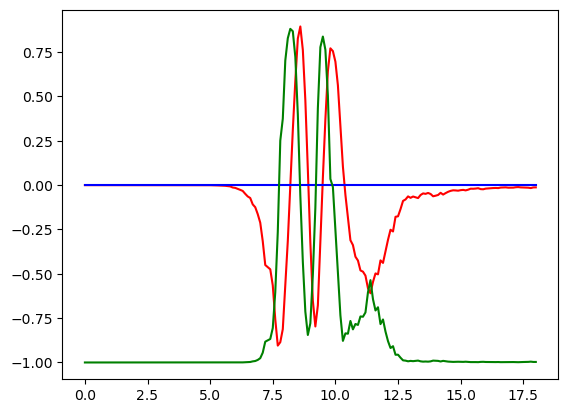

  0.002072 seconds (28.83 k allocations: 2.114 MiB)


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f961a0ee850>

In [18]:
Random.seed!(1)
dt0 = 1e-1
tt0, ρs0, dy = @time rouchon(T, ρ0, H, J, C; dt=dt0);
evs0 = expects.(ρs0)
evs0 = [evs0[n][ax] for n in 1:length(tt0), ax in 1:3]
plt.plot(tt0, evs0[:,1], "r")
plt.plot(tt0, evs0[:,2], "b")
plt.plot(tt0, evs0[:,3], "g")

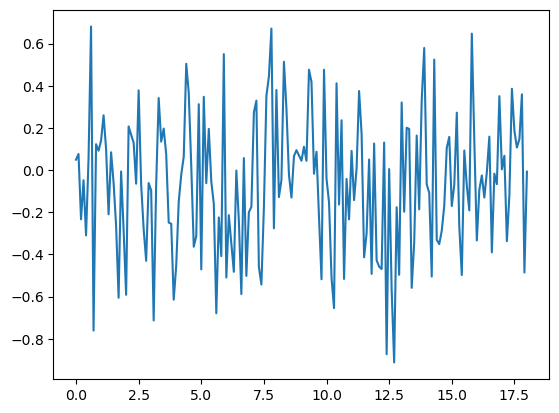

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9619f32340>

In [14]:
plt.plot(tt0, dy[1])

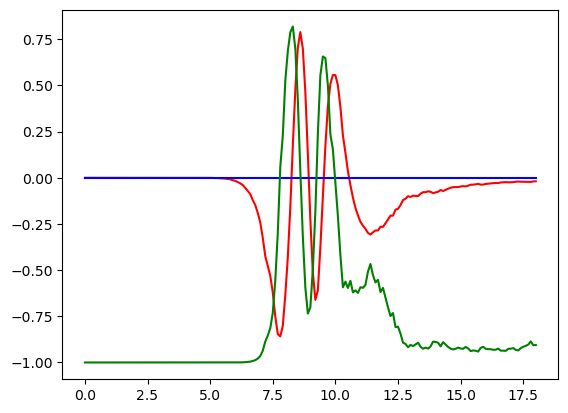

  0.391245 seconds (853.29 k allocations: 57.894 MiB, 4.92% gc time, 97.29% compilation time)


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f95f88b6df0>

In [15]:
Random.seed!(1)
dt1 = dt0
tt1, ρs1, dy1 = @time bayesian(T, ρ0, H, J, C; dt=dt1);
evs1 = expects.(ρs1)
evs1 = [evs1[n][ax] for n in 1:length(tt1), ax in 1:3]
plt.plot(tt1, evs1[:,1], "r")
plt.plot(tt1, evs1[:,2], "b")
plt.plot(tt1, evs1[:,3], "g")

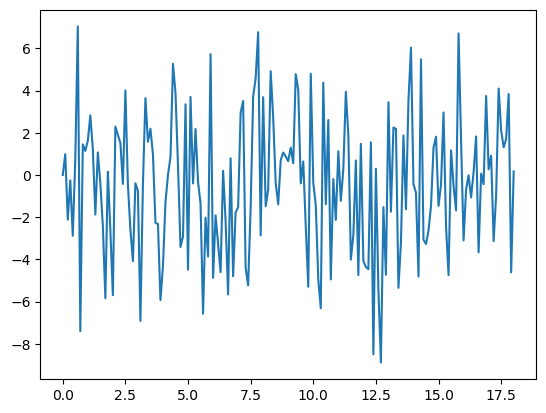

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15daa0d50>

In [45]:
plt.plot(tt1, dy1[1])

## Bayesian Test

In [52]:
# Parameters
n = 150 # ensemble size
Ω  = 2π # Rabi frequency
τ = 3.0 # Measurement collapse timescale
Γ = 1/(2τ) # Measurement dephasing rate
T = (0.0, 6τ) # Time duration of simulation
η = 0.3

# Basis
q = SpinBasis(1//2)

# Operators
σx = sigmax(q)
σy = sigmay(q)
σz = sigmaz(q)
id = identityoperator(q)

# Helper
expects = ρ -> collect(real(expect(ρ, s)) for s in [σx,σy,σz]) # ρ -> [<x>,<y>,<z>]
ispositive = ρ -> begin
  mineig = eigmin(real(ρ))
  if mineig > 0 || abs(mineig) < 1e-10
      return true
  else 
      return false
  end
end

F(ρ,σ) = norm(tr(sqrt(sqrt(σ.data)*ρ.data*sqrt(σ.data))))^2
average(ρt) = sum(ρt)'/size(ρt)[1]

average (generic function with 1 method)

In [20]:
Random.seed!(1)

dt = 1e-4
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt1, ρt1 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt1, ρct1 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  1.488604 seconds (26.59 M allocations: 1.966 GiB, 23.62% gc time)
  1.560597 seconds (26.46 M allocations: 1.958 GiB, 34.67% gc time)


In [21]:
Random.seed!(1)

dt = 1e-3
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt2, ρt2 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt2, ρct2 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  0.150452 seconds (2.64 M allocations: 200.701 MiB, 27.90% gc time)
  0.140953 seconds (2.64 M allocations: 200.701 MiB, 27.49% gc time)


In [22]:
Random.seed!(1)

dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt3, ρt3 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt3, ρct3 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  0.017213 seconds (262.24 k allocations: 20.029 MiB)
  0.014940 seconds (262.24 k allocations: 20.029 MiB)


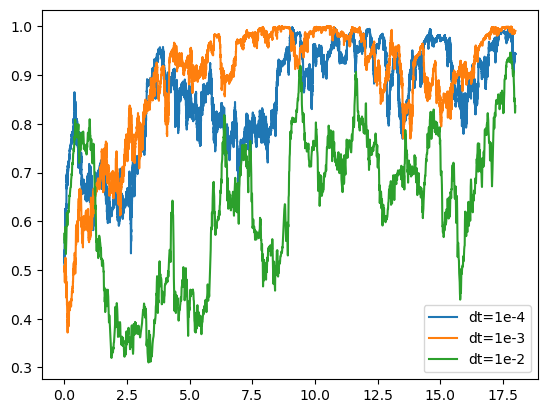

PyObject <matplotlib.legend.Legend object at 0x7f96031d2670>

In [23]:
plt.plot(tt1, F.(ρt1, ρct1), label="dt=1e-4")
plt.plot(tt2, F.(ρt2, ρct2), label="dt=1e-3")
plt.plot(tt3, F.(ρt3, ρct3), label="dt=1e-2")
plt.legend()

# Ensemble Average Fidelity Comparisons

In [24]:
@everywhere begin
dt = 1e-3
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

tt1, ρt1 = @time ensemble(rouchon, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
tt1, ρct1 = @time ensemble(rouchon, T, u, H0, [J0], [C0]; dt=dt, N=500);

 71.093408 seconds (1.33 G allocations: 98.230 GiB, 24.30% gc time, 0.97% compilation time)
178.058164 seconds (1.32 G allocations: 97.999 GiB, 69.56% gc time)


In [25]:
@everywhere begin
dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

tt3, ρt3 = @time ensemble(rouchon, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
tt3, ρct3 = @time ensemble(rouchon, T, u, H0, [J0], [C0]; dt=dt, N=500);

 22.211674 seconds (131.12 M allocations: 9.780 GiB, 75.11% gc time)
 19.305805 seconds (131.12 M allocations: 9.780 GiB, 72.31% gc time)


In [26]:
@everywhere begin
dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

btt2, bρt2 = @time ensemble(bayesian, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
btt2, bρct2 = @time ensemble(bayesian, T, u, H0, [J0], [C0]; dt=dt, N=500);

 51.081890 seconds (295.25 M allocations: 27.283 GiB, 38.71% gc time, 2.73% compilation time)
 52.787744 seconds (294.51 M allocations: 27.239 GiB, 43.11% gc time)


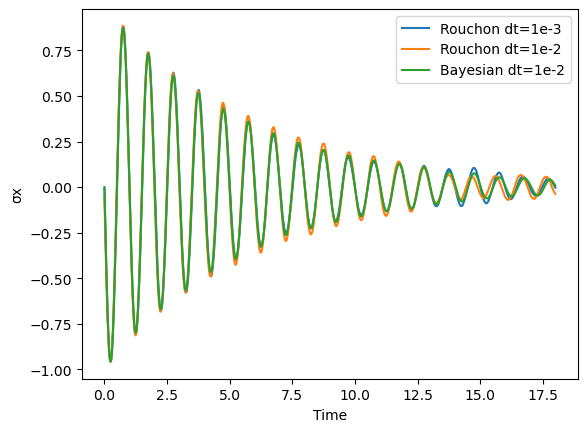

PyObject <matplotlib.legend.Legend object at 0x7f91dfc57d00>

In [125]:
plt.plot(tt1, map(x -> x[1], expects.(average(ρt1)[1,:])), label="Rouchon dt=1e-3")
plt.plot(btt2, map(x -> x[1], expects.(average(ρt3)[1,:])), label="Rouchon dt=1e-2")
plt.plot(btt2, map(x -> x[1], expects.(average(bρt2)[1,:])), label="Bayesian dt=1e-2")
plt.xlabel("Time")
plt.ylabel("σx")
plt.legend()

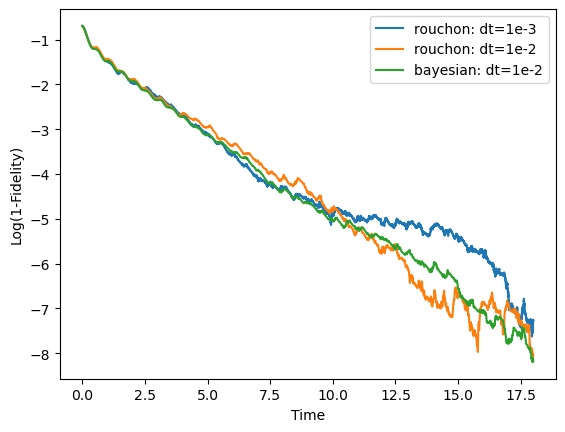

PyObject <matplotlib.legend.Legend object at 0x7f91dfa8edf0>

In [124]:
plt.plot(tt1, log.(1 .- F.(average(ρt1), average(ρct1)))[1,:], label="rouchon: dt=1e-3")
plt.plot(tt3, log.(1 .- F.(average(ρt3), average(ρct3)))[1,:], label="rouchon: dt=1e-2")
# plt.plot(tt1, log.(1 .- F.(average(ρt1), average(ρct1[1]))), label="rouchon: dt=1e-3")
plt.plot(btt2, log.(1 .- F.(average(bρt2), average(bρct2)))[1,:], label="bayesian: dt=1e-2")
# plt.plot(btt1, log.(1 .- F.(average(bρt1), average(bρct1))), label="bayesian: dt=1e-3")
plt.xlabel("Time")
plt.ylabel("Log(1-Fidelity)")
plt.legend()

# Coarse Graining

In [126]:
function coarsegrain(fine=[]; n=2)
    coarse = []
    for i in 1:length(fine)
        if i < n
            push!(coarse, mean(fine[1:i]))
        else
            push!(coarse, mean(fine[i-(n-1):i]))
        end
    end
    coarse
end

function select(a=[]; n=2)
    a[filter(x -> x%n==1, eachindex(a))]
end

select (generic function with 2 methods)

## No Unitary Evolution

In absence of unitary evolution, Bayesian update should be $dt$ invariant.

In [134]:
dt = 1e-2
ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

η = 1
J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = 0σz

T = (0,45)

scale=10

Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H0, [J0], [C0]; dt=dt/scale);
tt, ρtu, dyu = @time bayesian(T, u, H0, [J0], [C0]; dt=dt/scale, dy=dy);

ro = coarsegrain(dy[1]; n=scale)
ros = select(ro; n=scale)
tt2, ρt2, dy2 = @time bayesian(T, ρ0, H0, [J0], [C0]; dt=dt, dy=[ros]);
tt2, ρtu2, dyu2 = @time bayesian(T, u, H0, [J0], [C0]; dt=dt, dy=dy2);

  1.403698 seconds (14.54 M allocations: 1.370 GiB, 27.65% gc time)
 11.383679 seconds (12.29 M allocations: 16.322 GiB, 23.03% gc time)
  0.506719 seconds (1.95 M allocations: 327.178 MiB, 14.99% gc time, 53.67% compilation time)
  0.218110 seconds (1.23 M allocations: 280.880 MiB, 24.81% gc time)


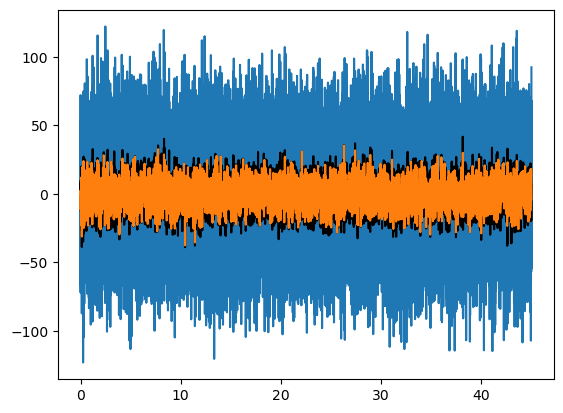

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f91b8128ac0>

In [128]:
plt.plot(tt, dy[1])
plt.plot(tt, coarsegrain(dy[1], n=scale), "black")
plt.plot(select(tt, n=scale), select(coarsegrain(dy[1], n=scale), n=scale))

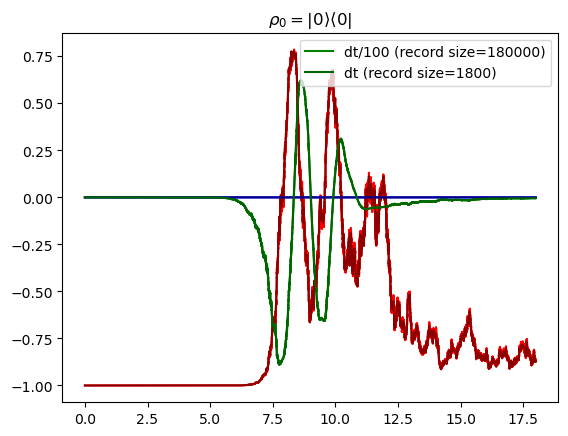

PyObject <matplotlib.legend.Legend object at 0x7f91d7d4e910>

In [150]:
evs = expects.(ρt)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,3], "red")
plt.plot(tt, evs[:,2], "blue")
plt.plot(tt, evs[:,1], "green", label="dt/$scale (record size=$(length(tt)-1))")

evs2 = expects.(ρt2)
evs2 = [evs2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evs2[:,3], "darkred")
plt.plot(tt2, evs2[:,2], "darkblue")
plt.plot(tt2, evs2[:,1], "darkgreen", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = |0\rightangle \leftangle 0|")
plt.legend()

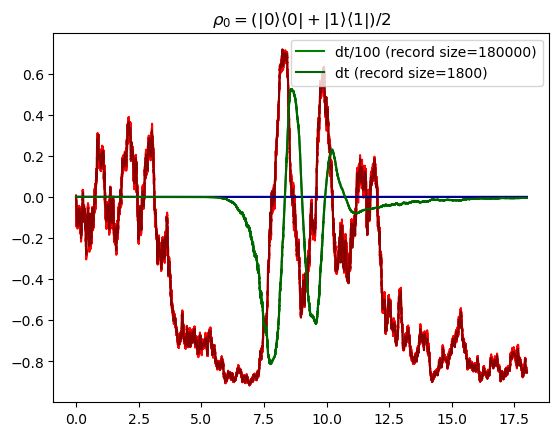

PyObject <matplotlib.legend.Legend object at 0x7f91d27caf70>

In [151]:
evsu = expects.(ρtu)
evsu = [evsu[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evsu[:,3], "red")
plt.plot(tt, evsu[:,2], "blue")
plt.plot(tt, evsu[:,1], "green", label="dt/$scale (record size=$(length(tt)-1))")

evsu2 = expects.(ρtu2)
evsu2 = [evsu2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evsu2[:,3], "darkred")
plt.plot(tt2, evsu2[:,2], "darkblue")
plt.plot(tt2, evsu2[:,1], "darkgreen", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = (|0\rightangle \leftangle 0| + |1\rightangle \leftangle 1|)/2")
plt.legend()

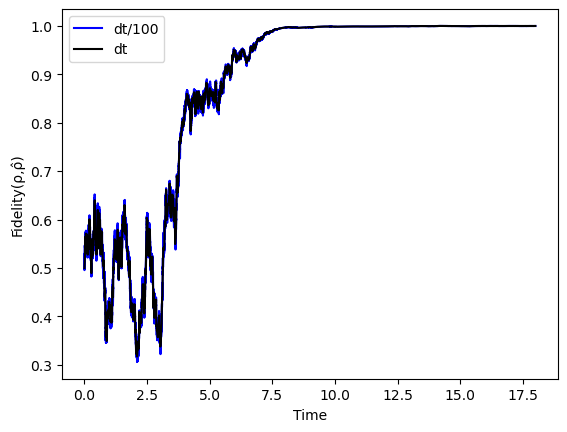

PyObject <matplotlib.legend.Legend object at 0x7f91d05c84c0>

In [158]:
plt.plot(tt, F.(ρt, ρtu), "blue", label="dt/$scale")
plt.plot(tt2, F.(ρt2, ρtu2), "black", label="dt")
plt.xlabel("Time")
plt.ylabel("Fidelity(ρ,ρ̂)")
plt.legend()

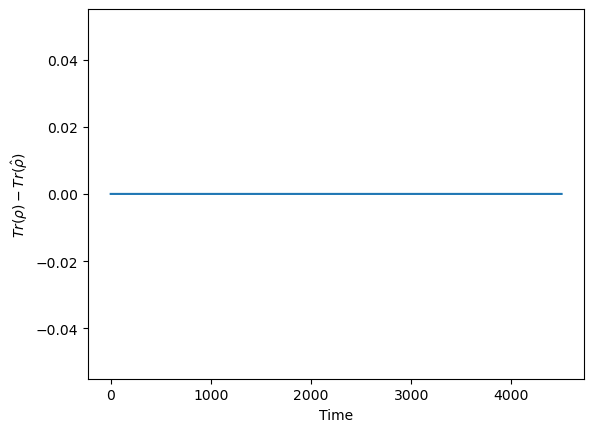

PyObject Text(30.236111111111114, 0.5, '$Tr(\\rho)-Tr(\\hat\\rho)$')

In [137]:
plt.plot(round.(tr.(select(ρt; n=scale) .- ρt2), digits=8))
plt.xlabel("Time")
plt.ylabel(L"Tr(\rho)-Tr(\hat\rho)")

## Unitary Evolution

In [144]:
dt = 1e-2
ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

T = (0, 6τ)

scale=100

Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H, [J0], [C0]; dt=dt/scale);
tt, ρtu, dyu = @time bayesian(T, u, H, [J0], [C0]; dt=dt/scale, dy=dy);

ro = coarsegrain(dy[1]; n=scale)
ros = select(ro; n=scale)
tt2, ρt2, dy2 = @time bayesian(T, ρ0, H, [J0], [C0]; dt=dt, dy=[ros]);
tt2, ρtu2, dyu2 = @time bayesian(T, u, H, [J0], [C0]; dt=dt, dy=dy2);

 11.187477 seconds (61.56 M allocations: 5.431 GiB, 44.07% gc time)
182.996617 seconds (52.82 M allocations: 246.306 GiB, 25.57% gc time, 0.07% compilation time)
  0.226617 seconds (789.38 k allocations: 92.718 MiB, 9.57% gc time, 59.89% compilation time)
  0.083436 seconds (525.18 k allocations: 75.084 MiB, 21.99% gc time)


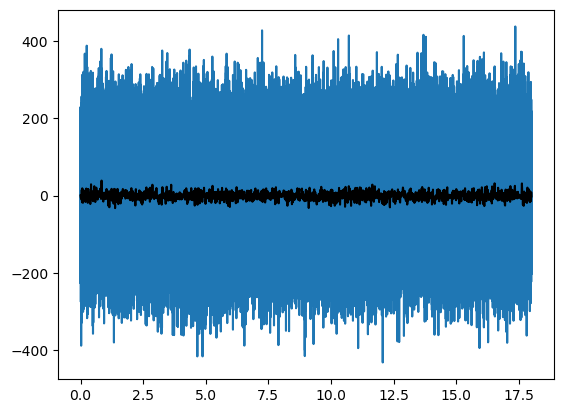

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f91caaad160>

In [145]:
plt.plot(tt, dy[1])
plt.plot(tt2, dy2[1], "black")

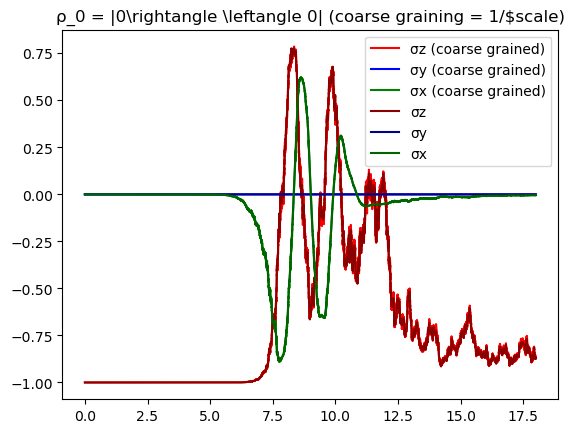

PyObject <matplotlib.legend.Legend object at 0x7f91d450fe20>

In [160]:
evs = expects.(ρt)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,3], "red", label="σz (coarse grained)")
plt.plot(tt, evs[:,2], "blue", label="σy (coarse grained)")
plt.plot(tt, evs[:,1], "green", label="σx (coarse grained)")

evs2 = expects.(ρt2)
evs2 = [evs2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evs2[:,3], "darkred", label="σz")
plt.plot(tt2, evs2[:,2], "darkblue", label="σy")
plt.plot(tt2, evs2[:,1], "darkgreen", label="σx")

plt.title(L"ρ_0 = |0\rightangle \leftangle 0| (coarse graining = 1/$scale)")
plt.legend()

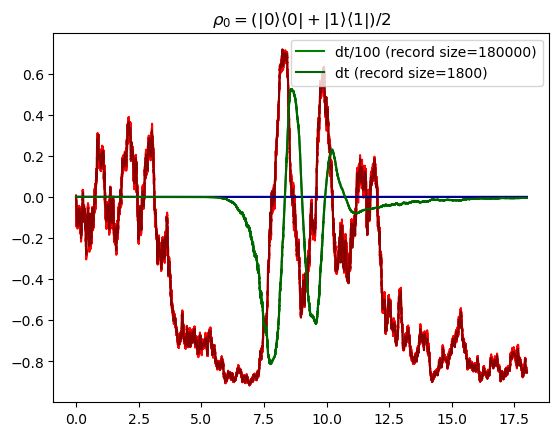

PyObject <matplotlib.legend.Legend object at 0x7f919a7d1fa0>

In [156]:
evsu = expects.(ρtu)
evsu = [evsu[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evsu[:,3], "red")
plt.plot(tt, evsu[:,2], "blue")
plt.plot(tt, evsu[:,1], "green", label="dt/$scale (record size=$(length(tt)-1))")

evsu2 = expects.(ρtu2)
evsu2 = [evsu2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evsu2[:,3], "darkred")
plt.plot(tt2, evsu2[:,2], "darkblue")
plt.plot(tt2, evsu2[:,1], "darkgreen", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = (|0\rightangle \leftangle 0| + |1\rightangle \leftangle 1|)/2")
plt.legend()

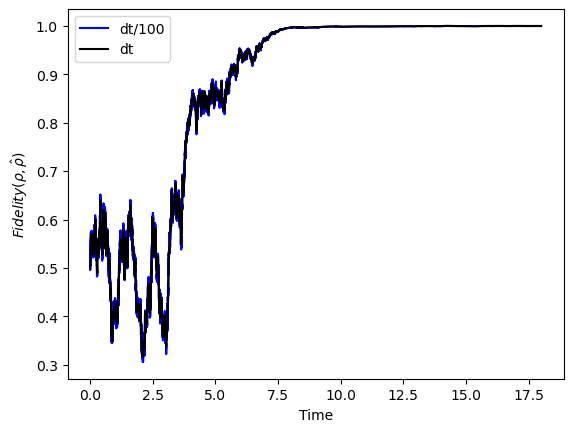

PyObject <matplotlib.legend.Legend object at 0x7f91d2989700>

In [148]:
plt.plot(tt, F.(ρt, ρtu), "blue", label="dt/$scale")
plt.plot(tt2, F.(ρt2, ρtu2), "black", label="dt")
plt.xlabel("Time")
plt.ylabel(L"Fidelity(\rho,\hat\rho)")
plt.legend()

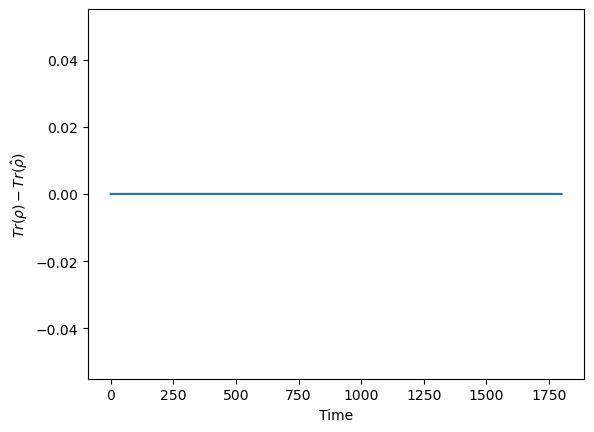

PyObject Text(30.236111111111114, 0.5, '$Tr(\\rho)-Tr(\\hat\\rho)$')

In [149]:
plt.plot(round.(tr.(select(ρt; n=scale) .- ρt2), digits=8))
plt.xlabel("Time")
plt.ylabel(L"Tr(\rho)-Tr(\hat\rho)")